In [16]:
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from tensorflow.keras.utils import plot_model

In [17]:
# 기본 생성 모델 정의
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

In [18]:
# 랜덤 벡터 생성
def generate_latent_points(latent_dim, n):
	# 표준 정규 분포표에서 랜덤하게 차원이 latent_dim인 n개의 벡터를 생성한다.
	x_input = randn(latent_dim * n)
	# 생성한 벡터들을 n, latent_dim의 형태로 재배치한다.
	x_input = x_input.reshape(n, latent_dim)
	return x_input

In [19]:
# 랜덤 벡터를 시각화
def generate_fake_samples(generator, latent_dim, n):
	# 랜덤 벡터를 생성 shpae == (n, latent_dim)
	x_input = generate_latent_points(latent_dim, n)
	# X를 예측한다. --> 예측 값으로 x,y 좌표를 얻기 위해서
	X = generator.predict(x_input)
	# 예측값의 1번 째, 2번 째 열을 x,y로 해 시각화 해준다.
	pyplot.scatter(X[:, 0], X[:, 1])
	pyplot.show()

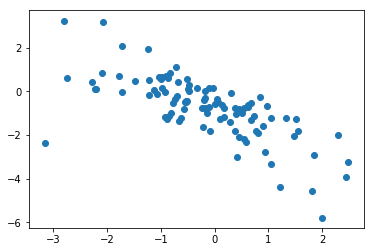

In [20]:
# 사용할 latent차원은 5
latent_dim = 5
# model에 기본 생성 모델을 넣어줌
model = define_generator(latent_dim)
# 랜덤 벡터를 생성하고 해당 벡터들을 시각화 해서 보여줌
generate_fake_samples(model, latent_dim, 100)

In [21]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

In [22]:
# 내가 생성한 가짜 데이터가 진짜 데이터와 비교 했을 때 어느정도 맞는지를 판단할 모델
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [23]:
# 생성기와 판별기를 결합한 GAN모델(판별기는 그대로 두고 생성기만 학습할 수 있도록 정의)
def define_gan(generator, discriminator):
	# 판별기의 가중치는 학습되지 않도록 설정
	discriminator.trainable = False
	# 모델 생성
	model = Sequential()
	# 생성기 연결
	model.add(generator)
	# 반펼기 연결
	model.add(discriminator)
	# 출력인 판별기 --> 맞는지 틀린지를 판별하기 때문에 binary_crossentropy
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [24]:
# 실제 데이터 생성(U 형태로 생성됨)
def generate_real_samples(n):
	X1 = rand(n) - 0.5
	X2 = X1 * X1
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	y = ones((n, 1))
	return X, y

In [25]:
# 가짜 데이터의 시각화가 아니라 x와 y를 반환 해줌
def generate_fake_samples(generator, latent_dim, n):
	x_input = generate_latent_points(latent_dim, n)
	X = generator.predict(x_input)
	y = zeros((n, 1))
	return X, y

In [26]:
# 특정 에포크에서 판별기의 성능을 평가하고, 실제와 가짜 데이터를 시각화
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# 실제 데이터의 x와 y값
	x_real, y_real = generate_real_samples(n)
	# 실제 데이터를 판별해 정확도 계산
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# 가짜 데이터의 x와 y값
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# 가짜 데이터를 판별해 정확도 계산
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	
    # 실제와 가짜 데이터의 각각의 판별기 정확도를 출력
	print(epoch, acc_real, acc_fake)
	# 실제와 가짜 데이터의 시각화
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()

In [27]:
# 생성기와 판별기 학습루프
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# 배치를 반으로 나눠 실제와 가짜의 배치를 각각 반씩 사용
	half_batch = int(n_batch / 2)
	# 에포크 반복
	for i in range(n_epochs):
		# 실제 데이터
		x_real, y_real = generate_real_samples(half_batch)
		# 가짜 데이터
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# 판별기 학습
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# 랜덤 벡터 생성
		x_gan = generate_latent_points(latent_dim, n_batch)
		# 가짜 샘플을 실제처럼 분류하는 라벨을 생성
		y_gan = ones((n_batch, 1))
		# 생성기가 판별기를 속일 수 있도록 GAN몯ㄹ 훈련
		gan_model.train_on_batch(x_gan, y_gan)
		# 에포크가 n_eval일 때마다 생성기와 판별기의 성능을 평가
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

1999 0.3499999940395355 1.0


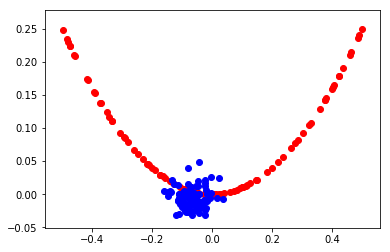

3999 0.3400000035762787 0.0


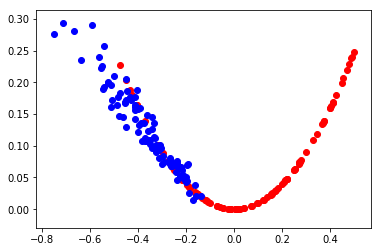

5999 0.27000001072883606 1.0


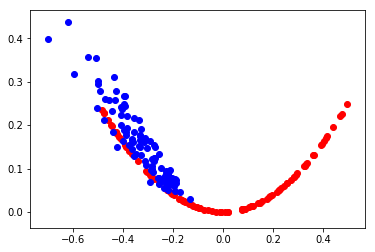

7999 0.4099999964237213 1.0


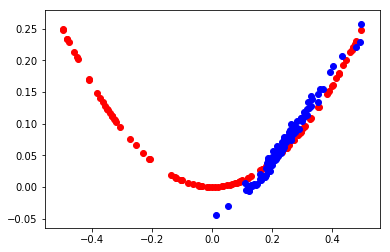

9999 0.41999998688697815 0.6399999856948853


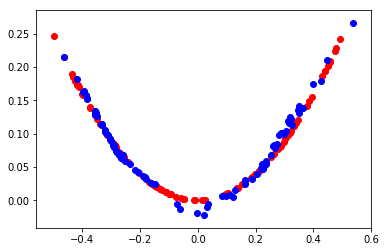

In [30]:
# 차원 설정
latent_dim = 5
# 판별기 생성
discriminator = define_discriminator()
# 생성기 생성
generator = define_generator(latent_dim)
# GAN 모델 생성
gan_model = define_gan(generator, discriminator)
# 생성기와 판별기 학습
train(generator, discriminator, gan_model, latent_dim)